# **SPRINT 01 DATA SCIENCE**

## Integrantes


*   Arthur Bobadilla Franchi RM 555056

*   Arthur Albuquerque Menezes RM 562950
*   Caio Rasuck Barbosa RM 93645
*   Jorge Luiz Silva Santos RM 554418
*   Luan Orlandelli Ramos RM 554747



## **Datasets**

### Criação do dataset

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Configurações básicas
np.random.seed(42)
random.seed(42)

# Criando parâmetros do dataset
unidades = ['Unidade A', 'Unidade B', 'Unidade C']
materiais = ['Seringa', 'Luvas', 'Álcool 70%', 'Kit Diagnóstico', 'Máscara']
responsaveis = ['Ana', 'Carlos', 'Fernanda', 'João', 'Larissa']
tipos_movimento = ['Entrada', 'Saída']
custo_unitario = {
    'Seringa': 2.5,
    'Luvas': 0.8,
    'Álcool 70%': 3.0,
    'Kit Diagnóstico': 50.0,
    'Máscara': 1.2
}

# Gerando os dados de tempo
dados = []
start_date = datetime.strptime("2024-01-01", "%Y-%m-%d")

# Gerando de forma aleatória o dataset
for _ in range(50):
    data = start_date + timedelta(days=random.randint(0, 120))
    unidade = random.choice(unidades)
    material = random.choice(materiais)
    tipo_mov = random.choice(tipos_movimento)
    responsavel = random.choice(responsaveis)

    # Quantidade normalmente distribuída, mas com alguns outliers
    if random.random() < 0.1:  # 10% chance de ser outlier
        quantidade = int(np.random.normal(200, 50))
    else:
        quantidade = int(np.random.normal(30, 10))

    quantidade = max(1, quantidade)  # Evitar quantidades negativas ou zero

    dados.append([data.date(), unidade, material, tipo_mov, quantidade, responsavel, custo_unitario[material]])

# Criação do DataFrame
df_simulado = pd.DataFrame(dados, columns=[
    'Data', 'Unidade', 'Material', 'TipoMovimento', 'Quantidade', 'Responsável', 'CustoUnitario'
])

df_simulado.head()


,Data,Unidade,Material,TipoMovimento,Quantidade,Responsável,CustoUnitario
0,2024-03-22,Unidade A,Seringa,Saída,34,Carlos,2.5
1,2024-04-04,Unidade A,Máscara,Entrada,28,Larissa,1.2
2,2024-01-04,Unidade A,Luvas,Entrada,36,Larissa,0.8
3,2024-03-12,Unidade A,Máscara,Saída,45,Carlos,1.2
4,2024-02-05,Unidade A,Luvas,Saída,27,Fernanda,0.8


### Analisando Outliers & Z-Score

In [ ]:
from scipy import stats

# Cópia do DataFrame para análise
df_analise = df_simulado.copy()

# Cálculo do Z-score apenas para dados com movimento de Saída
df_saida = df_analise[df_analise["TipoMovimento"] == "Saída"].copy()
df_saida["Z_score"] = stats.zscore(df_saida["Quantidade"])

# Aplicação do IQR para identificar outliers
Q1 = df_saida["Quantidade"].quantile(0.25)
Q3 = df_saida["Quantidade"].quantile(0.75)
IQR = Q3 - Q1

# Condição de outliers pelo IQR
df_saida["Outlier_IQR"] = (df_saida["Quantidade"] < (Q1 - 1.5 * IQR)) | (df_saida["Quantidade"] > (Q3 + 1.5 * IQR))

# Combinação dos resultados no DataFrame final
df_saida_resultado = df_saida[["Data", "Unidade", "Material", "Quantidade", "Z_score", "Outlier_IQR"]]
df_saida_resultado.head(51)


,Data,Unidade,Material,Quantidade,Z_score,Outlier_IQR
0,2024-03-22,Unidade A,Seringa,34,-0.058027,False
3,2024-03-12,Unidade A,Máscara,45,0.203096,False
4,2024-02-05,Unidade A,Luvas,27,-0.224196,False
6,2024-04-18,Unidade B,Máscara,45,0.203096,False
12,2024-01-21,Unidade B,Kit Diagnóstico,32,-0.105504,False
14,2024-01-09,Unidade A,Máscara,12,-0.580273,False
16,2024-04-05,Unidade C,Máscara,19,-0.414104,False
19,2024-02-24,Unidade C,Seringa,15,-0.509058,False
25,2024-01-03,Unidade A,Álcool 70%,205,4.001246,True
28,2024-01-22,Unidade B,Máscara,23,-0.319150,False


In [ ]:
# Cálculo de média e desvio padrão por material (somente saída)
df_saida = df_simulado[df_simulado["TipoMovimento"] == "Saída"].copy()
stats_por_material = df_saida.groupby("Material")["Quantidade"].agg(["mean", "std"]).reset_index()

# Total de saída por unidade
saida_por_unidade = df_saida.groupby("Unidade")["Quantidade"].sum().reset_index().rename(columns={"Quantidade": "TotalSaida"})

stats_por_material

,Material,mean,std
0,Kit Diagnóstico,28.250000,4.500000
1,Luvas,30.666667,6.350853
2,Máscara,26.000000,15.310127
3,Seringa,19.666667,12.662280
4,Álcool 70%,118.000000,123.036580


In [ ]:
# Detecção de outliers por IQR
outliers_por_unidade = df_saida.groupby("Unidade")["Outlier_IQR"].sum().reset_index().rename(columns={"Outlier_IQR": "QtdOutliers"})

# Unir métricas comparativas
comparativo_unidades = saida_por_unidade.merge(outliers_por_unidade, on="Unidade")

comparativo_unidades

,Unidade,TotalSaida,QtdOutliers
0,Unidade A,364,1
1,Unidade B,181,0
2,Unidade C,111,0


### Impacto acumulado

In [ ]:
# Filtrar apenas saídas
df_saida = df_simulado[df_simulado["TipoMovimento"] == "Saída"].copy()

# Calcular o custo real por linha
df_saida["CustoReal"] = df_saida["Quantidade"] * df_saida["CustoUnitario"]

# Converter datas e extrair mês
df_saida["Data"] = pd.to_datetime(df_saida["Data"])
df_saida["Mes"] = df_saida["Data"].dt.to_period("M")

# Simular erros e calcular impacto mensal e acumulado
erros = [0.10, 0.20, 0.30, 0.40, 0.50]
resultados = []

for erro in erros:
    df_saida[f"QtdComErro_{int(erro*100)}"] = df_saida["Quantidade"] * (1 + erro)
    df_saida[f"CustoComErro_{int(erro*100)}"] = df_saida[f"QtdComErro_{int(erro*100)}"] * df_saida["CustoUnitario"]
    df_saida[f"Impacto_{int(erro*100)}"] = df_saida[f"CustoComErro_{int(erro*100)}"] - df_saida["CustoReal"]

    # Impacto por mês
    impacto_mensal = df_saida.groupby("Mes")[f"Impacto_{int(erro*100)}"].sum().reset_index()
    impacto_mensal.columns = ["Mes", "ImpactoMensal"]
    impacto_mensal["Erro"] = f"{int(erro*100)}%"
    impacto_mensal["ImpactoAcumulado"] = impacto_mensal["ImpactoMensal"].cumsum()
    resultados.append(impacto_mensal)

# Concatenar tudo
impacto_total = pd.concat(resultados)

impacto_total

,Mes,ImpactoMensal,Erro,ImpactoAcumulado
0,2024-01,228.74,10%,228.74
1,2024-02,305.21,10%,533.95
2,2024-03,132.84,10%,666.79
3,2024-04,9.84,10%,676.63
0,2024-01,457.48,20%,457.48
1,2024-02,610.42,20%,1067.90
2,2024-03,265.68,20%,1333.58
3,2024-04,19.68,20%,1353.26
0,2024-01,686.22,30%,686.22
1,2024-02,915.63,30%,1601.85


### Custo mensal

In [ ]:
# Calcular custo mensal real
df_saida["Data"] = pd.to_datetime(df_saida["Data"])
df_saida["Mes"] = df_saida["Data"].dt.to_period("M")
custo_mensal_real = df_saida.groupby("Mes")["CustoReal"].sum().reset_index()

custo_mensal_real

,Mes,CustoReal
0,2024-01,2287.4
1,2024-02,3052.1
2,2024-03,1328.4
3,2024-04,98.4


## **Gráficos**

### Bibliotecas

In [ ]:
# Instalação de bibliotecas necessárias
!pip install -q seaborn plotly

# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats

### Gráficos Outliers & Z-Score

<ipython-input-17-698253fb0fde>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Material", y="Quantidade", data=df_saida, palette="Set2")


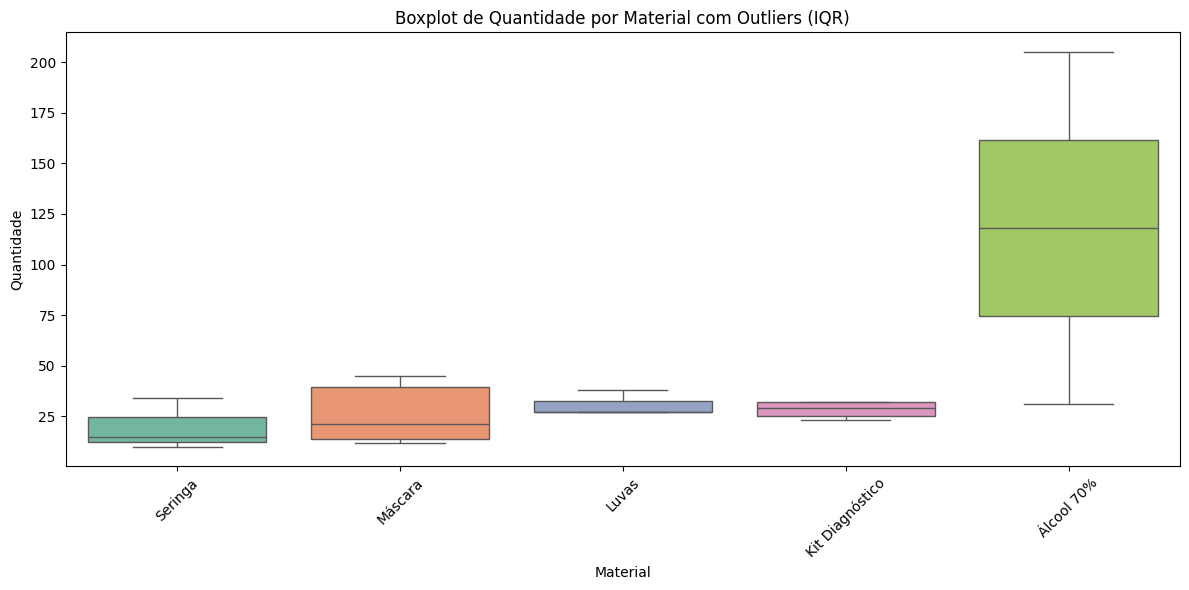

In [ ]:
# Exibição direta
%matplotlib inline

# Carregar os dados
df = df_simulado.copy()

# Filtrar apenas saídas e calcular Z-score
df_saida = df[df["TipoMovimento"] == "Saída"].copy()
df_saida["Z_score"] = stats.zscore(df_saida["Quantidade"])

# Boxplot por material com seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Material", y="Quantidade", data=df_saida, palette="Set2")
plt.xticks(rotation=45)
plt.title("Boxplot de Quantidade por Material com Outliers (IQR)")
plt.tight_layout()
plt.show()


In [ ]:
# Aplicar IQR
Q1 = df_saida["Quantidade"].quantile(0.25)
Q3 = df_saida["Quantidade"].quantile(0.75)
IQR = Q3 - Q1
df_saida["Outlier_IQR"] = (df_saida["Quantidade"] < (Q1 - 1.5 * IQR)) | (df_saida["Quantidade"] > (Q3 + 1.5 * IQR))

# Gráfico interativo com Plotly
fig = px.box(df_saida, x="Material", y="Quantidade", color="Outlier_IQR",
             title="Boxplot Interativo por Material - Destaque nos Outliers")
fig.show()

### Gráfico saída unidade

<ipython-input-16-bcb157ab6a3b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=saida_por_unidade, x="Unidade", y="TotalSaida", palette="Blues_d")


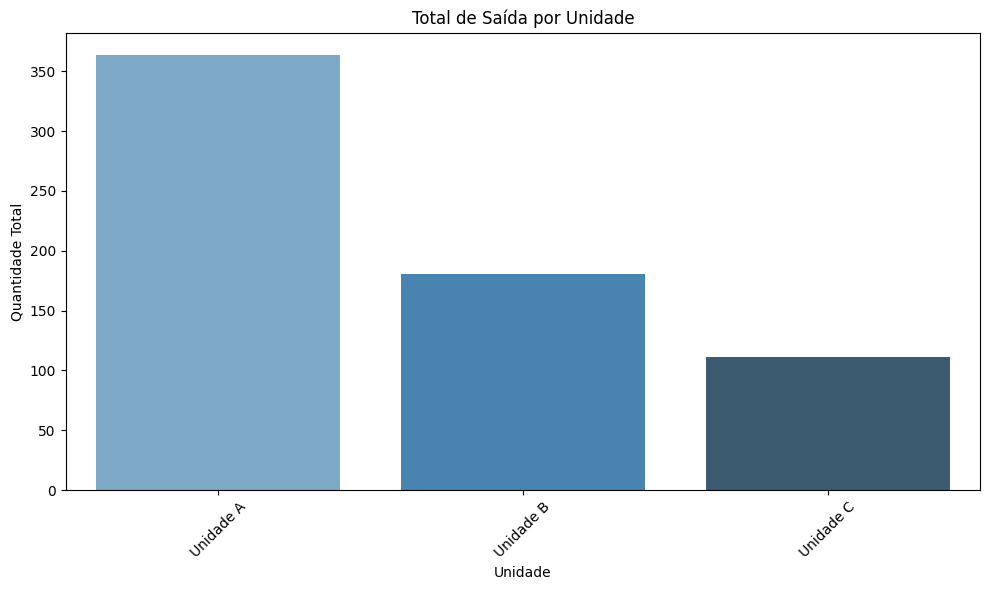

In [ ]:
# Total de saída por unidade
saida_por_unidade = df_saida.groupby("Unidade")["Quantidade"].sum().reset_index().rename(columns={"Quantidade": "TotalSaida"})

# Gráfico de barras com total de saída por unidade
plt.figure(figsize=(10,6))
sns.barplot(data=saida_por_unidade, x="Unidade", y="TotalSaida", palette="Blues_d")
plt.title("Total de Saída por Unidade")
plt.ylabel("Quantidade Total")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Gráfico custo mensal

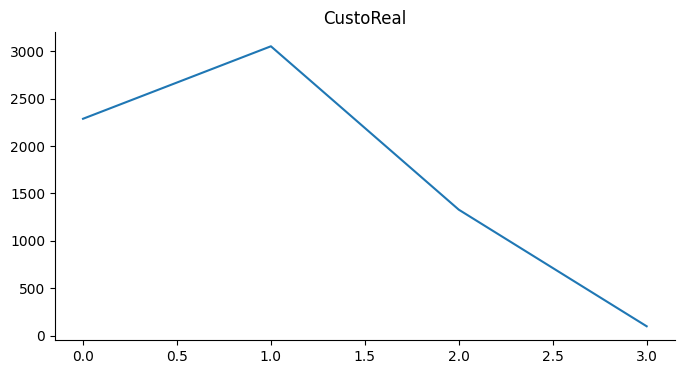

In [ ]:
# Gráfico de linhas custo real
custo_mensal_real['CustoReal'].plot(kind='line', figsize=(8, 4), title='CustoReal')
plt.gca().spines[['top', 'right']].set_visible(False)

### Gráfico impacto acumulado

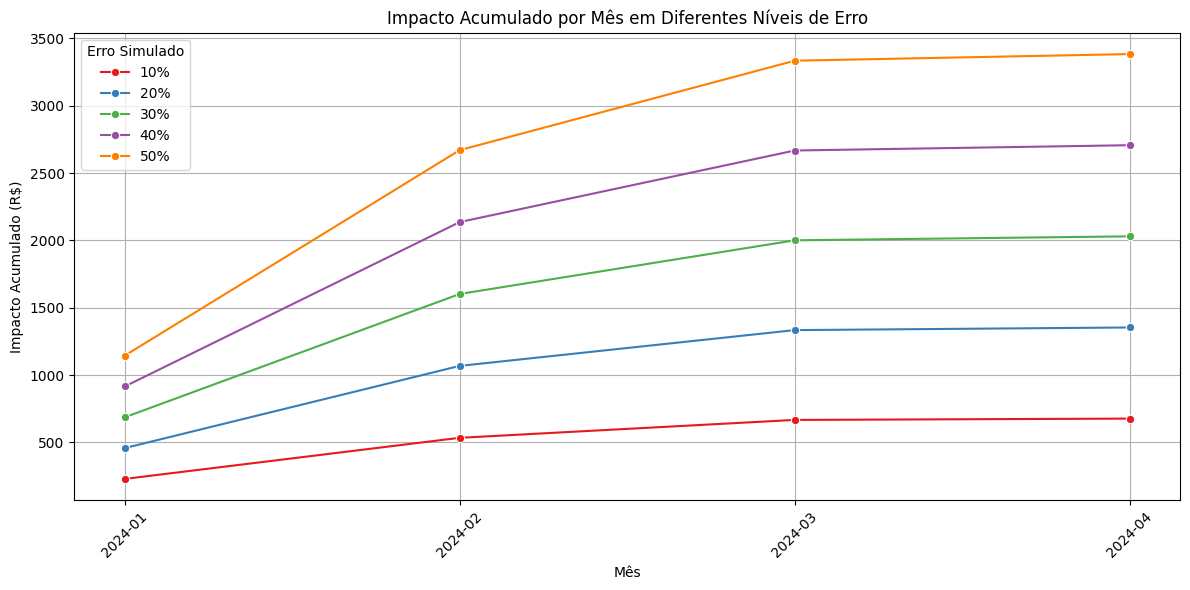

In [ ]:
# Converter a coluna Mes de Period para string (caso necessário)
impacto_total["Mes"] = impacto_total["Mes"].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=impacto_total, x="Mes", y="ImpactoAcumulado", hue="Erro", marker="o", palette="Set1")

plt.title("Impacto Acumulado por Mês em Diferentes Níveis de Erro")
plt.xlabel("Mês")
plt.ylabel("Impacto Acumulado (R$)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Erro Simulado")
plt.show()
